In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy.core.defchararray import add
import seaborn as sns
import pycbc.conversions as convert

# the idea of bhattacharya coefficient or distance

Calculate overlap in masses using the matched filtered masses and the SNR for rapidly identifying the interesting pairs.


$\rho_{obs} = \rho_{inj} - N(0,1)$


$ M_{obs} = N(M_{MF}, \sigma /\rho_{obs} . M_{MF}) $


Bhattacharya distance between two Gaussians: http://en.wikipedia.org/wiki/Bhattacharyya_distance

Bhattacharya coeff (prior independent quantity): $\int \sqrt{P(\theta|d_1)P(\theta|d_2)}d\theta$

# approximating $M_{MF}$ and $\Delta M_{obs}$ for the injections
Iteratively:-

$\rho_{obs} = \rho_{inj} - N(0,1)$


$\Delta M_{guess} = \sigma /\rho_{obs} . M_{inj} $ 

$M_{MF} = N(M_{inj},\Delta M_{guess})$

$\Delta M_{obs} = \sigma /\rho_{obs} . M_{MF} , M_{obs} = N(M_{MF}, \sigma /\rho_{obs} . M_{MF}) $

In [2]:
def gaussian_dist(x,mu=0,sig=1):
    return 1/(sig*np.sqrt(2*np.pi)) * np.exp(-0.5*((x-mu)/sig)**2)

In [3]:
def bhattacharya_coeff(mu1,mu2,sig1,sig2,theta=np.linspace(1,1001,10000)):
    bc=[]
    for i in range(len(mu1)):
        gd1=gaussian_dist(theta,mu1[i],sig1[i])
        gd2=gaussian_dist(theta,mu2[i],sig2[i])
        bc.append((np.sqrt(gd1*gd2)*np.diff(theta)[0]).sum())  
    return np.array(bc)
def bhattacharya_dist(mu1,mu2,sig1,sig2):
    return 1/4 * np.log(1/4 * ((sig1/sig2)**2 + (sig2/sig1)**2 + 2 ) ) + 1/4 * ((mu1-mu2)**2) / (sig1**2 + sig2**2)


    

In [4]:
def get_Mobs_injection(snr_inj, m_inj,s=0.08*8):
    snr_obs = snr_inj - np.random.randn(len(snr_inj))
    sig_M_guess = m_inj*(s/snr_obs)
    M_mf = m_inj + np.random.randn(len(snr_inj))*sig_M_guess
    sig_mf = M_mf*(s/snr_obs)
    return M_mf, sig_mf

In [5]:
mu1,sig1 = get_Mobs_injection([30,100], [40,20],s=0.08*8)
mu2,sig2 = get_Mobs_injection([10,100], [40,20],s=0.08*8)
bhattacharya_coeff(mu1,mu2,sig1,sig2)

array([0.73456954, 0.51713659])

In [6]:
lensed_data = dict(np.load("../data/injection_pars/training/dominik_plaw2_lensed_inj_params_include_pol_phi0.npz"))
unlensed_data = pd.read_csv("../data/injection_pars/training/analytical_psd_Dominik_powerlaw2_inj_samples_withsnr.dat",delimiter='\t')

In [7]:
lensed_data_haris= dict(np.load('../data/injection_pars/haris-et-al/lensed_inj_data.npz'))
unlensed_data_haris= dict(np.load('../data/injection_pars/haris-et-al/unlensed_inj_data.npz'))
unlensed_data_O3a_inj= dict(np.load('../data/injection_pars/O3a/injections_samples_o3a_newrun_Belczynski_image1_LHV_withsnr_filtered.npz'))



In [8]:
mchirp_lensed = convert.mchirp_from_mass1_mass2(lensed_data['m1'],lensed_data['m2'])
mchirp_lensed_haris = convert.mchirp_from_mass1_mass2(lensed_data_haris['m1'],lensed_data_haris['m2'])


/home/srashti.goyal/.local/lib/python3.7/site-packages/pycbc/conversions.py:139: RuntimeWarning: invalid value encountered in true_divide
  return mass1*mass2 / (mass1+mass2)**2.


In [9]:
#unlensed_data= dict(np.load('../data/injection_pars/haris-et-al/unlensed_inj_data.npz'))

m1,m2 = unlensed_data_haris['m1z'],unlensed_data_haris['m2z']
mchirp_ul = convert.mchirp_from_mass1_mass2(m1,m2)


/home/srashti.goyal/.conda/envs/igwn-py37-hanabi/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/srashti.goyal/.conda/envs/igwn-py37-hanabi/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


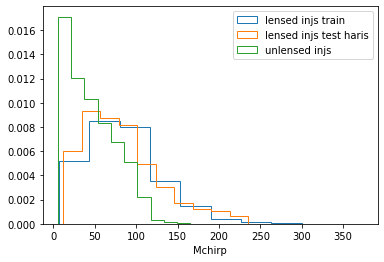

In [10]:
plt.hist(mchirp_lensed,histtype='step',label='lensed injs train',density=True)
plt.hist(mchirp_lensed_haris,histtype='step',label='lensed injs test haris',density=True)
plt.hist(mchirp_ul,histtype='step',label='unlensed injs',density=True)
plt.legend()
plt.xlabel('Mchirp')
plt.show()

# bhattacharya on the test set

In [11]:
base_dir = '/home/srashti.goyal/strong-lensing-ml/' #CIT

In [12]:
df_test=pd.read_csv(base_dir + 'data/dataframes/test/ML_combined_kaggle.csv',index_col=0)
df_test.columns

Index(['img_0', 'img_1', 'Lensing', 'bayestar_skymaps_blu',
       'bayestar_skymaps_d2', 'bayestar_skymaps_d3', 'bayestar_skymaps_lsq',
       'm1, m2, ra, sin_dec, a1, a2, costilt1, costilt2, costheta_jn',
       'm1, m2, ra, sin_dec, costheta_jn', 'ra, sin_dec',
       '# m1, m2, ra, sin_dec, a1, a2, costilt1, costilt2',
       'm1, m2, ra, sin_dec', 'm1, m2', 'xgb_pred_bayestar_skymaps',
       'xgb_pred_bayestar_skymaps_1', 'xgb_pred_bayestar_skymaps_2',
       'xgb_pred_bayestar_skymaps_3', 'xgb_pred_bayestar_skymaps_4',
       'xgb_pred_bayestar_skymaps_5', 'xgb_pred_bayestar_skymaps_6',
       'xgb_pred_bayestar_skymaps_7', 'xgb_pred_bayestar_skymaps_8',
       'xgb_pred_bayestar_skymaps_9', 'xgb_pred_bayestar_skymaps_10',
       'xgb_pred_bayestar_skymaps_fpp', 'ra, sin_dec_fpp', 'dense_H1_0',
       'mean_overlap_qts_H1', 'std_overlap_qts_H1', 'lsq_overlap_qts_H1',
       'dense_L1_0', 'mean_overlap_qts_L1', 'std_overlap_qts_L1',
       'lsq_overlap_qts_L1', 'dense_V1_0', 'me

In [13]:
df_test_old=pd.read_csv(base_dir + 'data/dataframes/test/MLEs_haris_et_al_inc_mchirp_inc_bhattacharya.csv',index_col=0)
df_test_old.columns

Index(['Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1',
       'Unnamed: 0.1.1.1.1', 'Unnamed: 0.1.1.1.1.1', 'Unnamed: 0.1.1.1.1.1.1',
       'img_0', 'img_1', 'Lensing', 'pe_skymaps_blu',
       ...
       'costheta_jn_MLE_img_0', 'costheta_jn_MLE_img_1', 'logl_MLE_img_0',
       'logl_MLE_img_1', 'matched_filter_snr_MLE_img_0',
       'matched_filter_snr_MLE_img_1', 'mchirp_MLE_img_1', 'mchirp_MLE_img_0',
       'mchirp_abs_diff', 'bhattacharya_coeff'],
      dtype='object', length=116)

In [14]:
cols_old = ['img_0', 'img_1', 'Lensing','m1_MLE_img_0',
       'm1_MLE_img_1', 'm2_MLE_img_0', 'm2_MLE_img_1', 'ra_MLE_img_0',
       'ra_MLE_img_1', 'dec_MLE_img_0', 'dec_MLE_img_1', 'a1_MLE_img_0',
       'a1_MLE_img_1', 'a2_MLE_img_0', 'a2_MLE_img_1',
       'costilt1_MLE_img_0', 'costilt1_MLE_img_1', 'costilt2_MLE_img_0',
       'costilt2_MLE_img_1', 'costheta_jn_MLE_img_0',
       'costheta_jn_MLE_img_1', 'logl_MLE_img_0', 'logl_MLE_img_1',
       'matched_filter_snr_MLE_img_0', 'matched_filter_snr_MLE_img_1',
       'mchirp_MLE_img_1', 'mchirp_MLE_img_0', 'mchirp_abs_diff',
       'bhattacharya_coeff']

In [15]:
df_test=pd.merge(df_test,df_test_old[cols_old],on=['img_0','img_1','Lensing'])

In [16]:
df_lensed=df_test[df_test['Lensing'] == 1]


In [17]:
tags=df_lensed['img_0'].str.rsplit('_',1).values


In [18]:
ids=[]
event_tags=[]
for event in tags:
    event_tag=event[0]
    idx=np.where(event_tag==lensed_data_haris['event_tag'])[0][0]
    ids.append(idx),event_tags.append(event_tag)
df_lensed['inj_id']=ids
df_lensed['event_tag'] = event_tags
df_lensed.tail()

/home/srashti.goyal/.conda/envs/igwn-py37-hanabi/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/srashti.goyal/.conda/envs/igwn-py37-hanabi/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,img_0,img_1,Lensing,bayestar_skymaps_blu,bayestar_skymaps_d2,bayestar_skymaps_d3,bayestar_skymaps_lsq,"m1, m2, ra, sin_dec, a1, a2, costilt1, costilt2, costheta_jn","m1, m2, ra, sin_dec, costheta_jn","ra, sin_dec",...,logl_MLE_img_0,logl_MLE_img_1,matched_filter_snr_MLE_img_0,matched_filter_snr_MLE_img_1,mchirp_MLE_img_1,mchirp_MLE_img_0,mchirp_abs_diff,bhattacharya_coeff,inj_id,event_tag
490577,6_16_904331947.740842819-1,6_16_904173839.556039214-2,1,2.275851,0.018350,0.127786,0.090225,3.582853e-02,2.686409e-02,0.507282,...,-96552.844879,-96556.291900,6.930910,9.665978,25.369051,102.805446,77.436395,418.759730,91,6_16
490720,6_22752_709667239.609254956-1,6_22752_709666750.975001573-2,1,2.552095,0.020577,0.100705,0.042598,3.263769e+02,4.604500e+02,86.145276,...,-96710.809875,-96389.789505,12.804305,13.007717,122.701334,77.258684,45.442650,19.259340,135,6_22752
491850,8_10927_770537300.748850345-1,8_10927_770537245.180587172-2,1,3.282096,0.026463,0.489408,0.164884,2.508265e+02,4.315757e+02,19.155077,...,-96643.191885,-96194.996332,10.331978,9.119739,97.257959,62.934768,34.323191,44.769872,284,8_10927
498479,7_1004_852645287.421835184-1,7_1004_852645287.399521112-2,1,8326.266857,67.133721,16158.560208,0.044169,2.577874e+08,8.261594e+07,7172.064872,...,-96719.263887,-95788.053521,61.120581,60.722037,64.105714,63.462856,0.642858,0.000959,260,7_1004
499001,2_4335_838371833.252562880-1,2_4335_838365919.945103406-2,1,5.026069,0.040525,0.447944,0.226178,2.881256e+02,1.333246e+03,21.632364,...,-96351.552225,-96452.009790,14.672954,13.251614,91.400402,104.363475,12.963073,1.686823,279,2_4335


In [19]:
df_unlensed=df_test[df_test['Lensing'] == 0]

event_id_dict=dict(zip(unlensed_data_haris['event_tag'],np.arange(len(unlensed_data_haris['event_tag']))))

In [20]:
unlensed_data_haris.keys()

dict_keys(['data_dir', 'event_tag', 'm1z', 'm2z', 'iota', 'ra', 'dec', 'tc', 'ldistance', 'snr', 'phi0', 'pol'])

In [21]:
df_unlensed['id_0'] = [event_id_dict[tag] for tag in df_unlensed['img_0'].values]
df_unlensed['id_1'] = [event_id_dict[tag] for tag in df_unlensed['img_1'].values]

/home/srashti.goyal/.conda/envs/igwn-py37-hanabi/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/srashti.goyal/.conda/envs/igwn-py37-hanabi/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
df_unlensed['snr_0']=unlensed_data_haris['snr'][df_unlensed['id_0']]
df_unlensed['snr_1']=unlensed_data_haris['snr'][df_unlensed['id_1']]


df_unlensed['mtotal_0'] = unlensed_data_haris['m1z'][df_unlensed['id_0']]+unlensed_data_haris['m2z'][df_unlensed['id_0']]
df_unlensed['mtotal_1'] = unlensed_data_haris['m1z'][df_unlensed['id_1']]+unlensed_data_haris['m2z'][df_unlensed['id_1']]
df_unlensed['snr_total'] = unlensed_data_haris['snr'][df_unlensed['id_0']]+unlensed_data_haris['snr'][df_unlensed['id_1']]

/home/srashti.goyal/.conda/envs/igwn-py37-hanabi/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/srashti.goyal/.conda/envs/igwn-py37-hanabi/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/srashti.goyal/.conda/envs/igwn-py37-hanabi/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [23]:
df_unlensed['mchirp_0'] = convert.mchirp_from_mass1_mass2(unlensed_data_haris['m1z'][df_unlensed['id_0']],unlensed_data_haris['m2z'][df_unlensed['id_0']])
df_unlensed['mchirp_1'] = convert.mchirp_from_mass1_mass2(unlensed_data_haris['m1z'][df_unlensed['id_1']],unlensed_data_haris['m2z'][df_unlensed['id_1']])


/home/srashti.goyal/.conda/envs/igwn-py37-hanabi/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/srashti.goyal/.conda/envs/igwn-py37-hanabi/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [24]:
df_lensed['mtotal']= lensed_data_haris['m1'][df_lensed['inj_id']]+lensed_data_haris['m2'][df_lensed['inj_id']]

/home/srashti.goyal/.conda/envs/igwn-py37-hanabi/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [25]:
df_lensed['mchirp_0']= convert.mchirp_from_mass1_mass2(lensed_data_haris['m1'][df_lensed['inj_id']],lensed_data_haris['m2'][df_lensed['inj_id']])
df_lensed['mchirp_1']= convert.mchirp_from_mass1_mass2(lensed_data_haris['m1'][df_lensed['inj_id']],lensed_data_haris['m2'][df_lensed['inj_id']])

/home/srashti.goyal/.conda/envs/igwn-py37-hanabi/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/srashti.goyal/.conda/envs/igwn-py37-hanabi/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [26]:
df_lensed['snr_0']=lensed_data_haris['snr'][df_lensed['inj_id']][:,0]
df_lensed['snr_1']=lensed_data_haris['snr'][df_lensed['inj_id']][:,1]
df_lensed['snr_total'] = df_lensed['snr_0']+df_lensed['snr_1']

/home/srashti.goyal/.conda/envs/igwn-py37-hanabi/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/srashti.goyal/.conda/envs/igwn-py37-hanabi/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/srashti.goyal/.conda/envs/igwn-py37-hanabi/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [27]:
df_test_new = pd.concat([df_lensed,df_unlensed])

In [28]:
df_test_new.columns

Index(['img_0', 'img_1', 'Lensing', 'bayestar_skymaps_blu',
       'bayestar_skymaps_d2', 'bayestar_skymaps_d3', 'bayestar_skymaps_lsq',
       'm1, m2, ra, sin_dec, a1, a2, costilt1, costilt2, costheta_jn',
       'm1, m2, ra, sin_dec, costheta_jn', 'ra, sin_dec',
       ...
       'mtotal', 'mchirp_0', 'mchirp_1', 'snr_0', 'snr_1', 'snr_total', 'id_0',
       'id_1', 'mtotal_0', 'mtotal_1'],
      dtype='object', length=102)

In [29]:
df_test_new['mchirp_mf_0'],df_test_new['delta_mchirp_mf_0']  = get_Mobs_injection(df_test_new['snr_0'],df_test_new['mchirp_0'])
df_test_new['mchirp_mf_1'],df_test_new['delta_mchirp_mf_1']  = get_Mobs_injection(df_test_new['snr_1'],df_test_new['mchirp_1'])

In [30]:
df_test_new['bhattacharya_coeff_mchirp']=bhattacharya_coeff(df_test_new['mchirp_mf_0'],df_test_new['mchirp_mf_1'],df_test_new['delta_mchirp_mf_0'],df_test_new['delta_mchirp_mf_1'])

df_test_new['bhattacharya_dist_mchirp']=bhattacharya_dist(df_test_new['mchirp_mf_0'],df_test_new['mchirp_mf_1'],df_test_new['delta_mchirp_mf_0'],df_test_new['delta_mchirp_mf_1'])

/home/srashti.goyal/.conda/envs/igwn-py37-hanabi/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


In [47]:
df_test_new.to_csv('df_test_bhattu.csv')

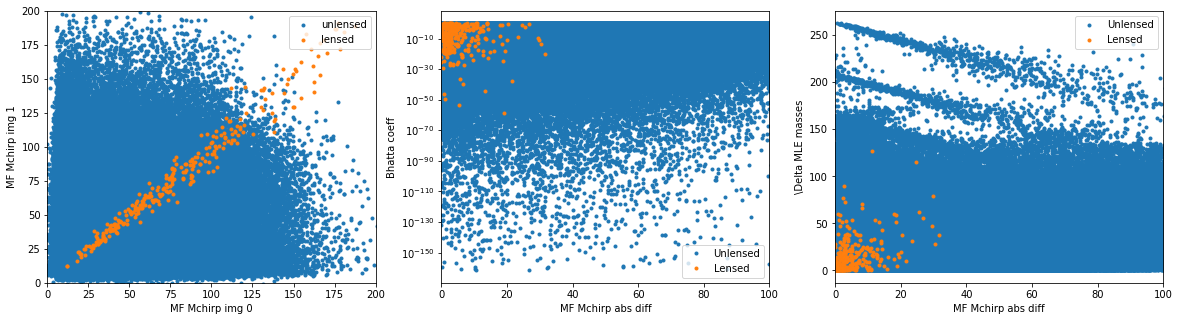

In [49]:
plt.figure(figsize=(20,5))
df_l=df_test_new[df_test_new['Lensing'] == 1]
df_ul=df_test_new[df_test_new['Lensing'] == 0]
plt.subplot(131)


plt.plot(df_ul['mchirp_mf_0'],df_ul['mchirp_mf_1'],'.',label = 'unlensed')
plt.plot(df_l['mchirp_mf_0'],df_l['mchirp_mf_1'],'.',label = 'lensed')
plt.xlim(0,200)
plt.ylim(0,200)
plt.xlabel('MF Mchirp img 0')
plt.ylabel('MF Mchirp img 1')
plt.legend()
plt.subplot(132)
plt.plot(np.abs(df_ul['mchirp_mf_0']-df_ul['mchirp_mf_1']),df_ul['bhattacharya_coeff_mchirp'],'.',label = 'Unlensed')
plt.plot(np.abs(df_l['mchirp_mf_0']-df_l['mchirp_mf_1']),df_l['bhattacharya_coeff_mchirp'],'.',label = 'Lensed')
plt.xlim(0,100)
plt.yscale('log')
plt.xlabel('MF Mchirp abs diff')
plt.ylabel('Bhatta coeff')
plt.legend()

plt.subplot(133)
plt.plot(np.abs(df_ul['mchirp_mf_0']-df_ul['mchirp_mf_1']),df_ul['mchirp_abs_diff'],'.',label = 'Unlensed')
plt.plot(np.abs(df_l['mchirp_mf_0']-df_l['mchirp_mf_1']),df_l['mchirp_abs_diff'],'.',label = 'Lensed')
plt.xlim(0,100)
#plt.yscale('log')
plt.xlabel('MF Mchirp abs diff')
plt.ylabel('\Delta MLE masses')
plt.legend()
plt.show()


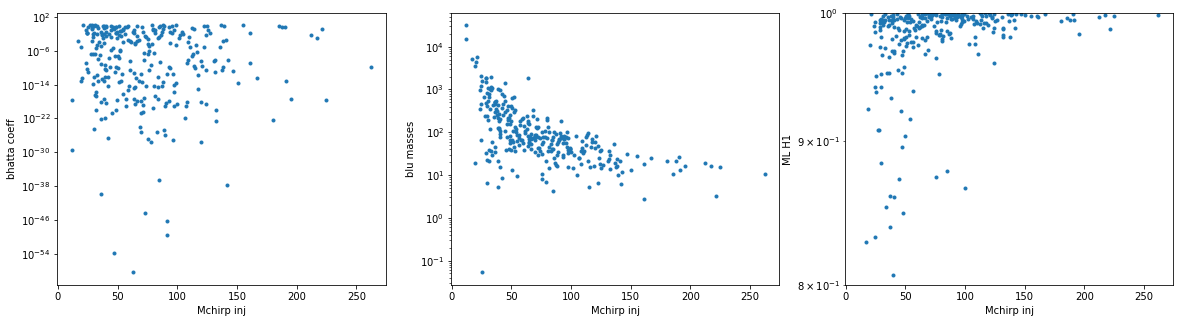

In [46]:
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.plot(df_l['mchirp_MLE_img_1'],df_l['bhattacharya_coeff_mchirp'],'.',label = 'Lensed')
plt.yscale('log')
plt.xlabel('Mchirp inj')
plt.ylabel('bhatta coeff')
#plt.ylim(1e-25,1.1e0)
plt.subplot(132)
plt.plot(df_l['mchirp_MLE_img_1'],df_l['m1, m2'],'.',label = 'Lensed')
plt.yscale('log')
plt.xlabel('Mchirp inj')
plt.ylabel('blu masses')

plt.subplot(133)
plt.plot(df_l['mchirp_MLE_img_1'],df_l['dense_H1_0'],'.',label = 'Lensed')
plt.xlabel('Mchirp inj')
plt.ylabel('ML H1')
plt.yscale('log')
plt.ylim(8e-1,1e0)
plt.show()

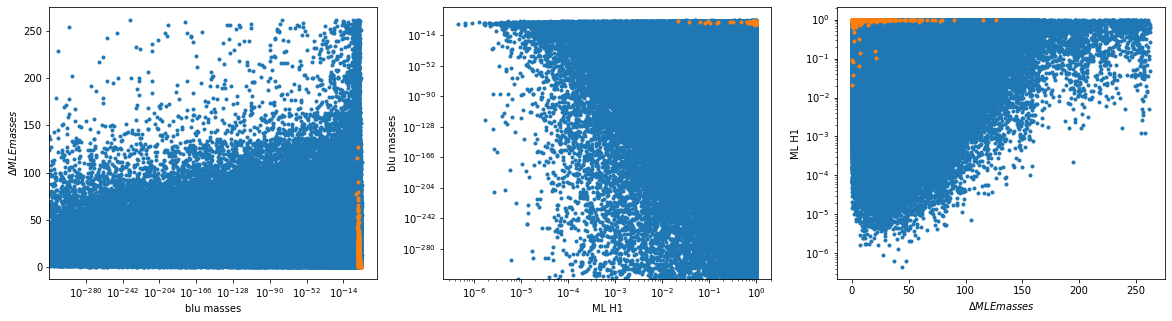

In [43]:
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.plot(df_ul['m1, m2'],df_ul['mchirp_abs_diff'],'.',label = 'Unlensed')
#

plt.plot(df_l['m1, m2'],df_l['mchirp_abs_diff'],'.',label = 'Lensed')
#plt.yscale('log')
plt.xscale('log')
#plt.xlim(1e0,1e3)
#plt.ylim(1e-25,1e0)


plt.xlabel('blu masses')

plt.ylabel('$\Delta MLE masses$')
#plt.ylim(1e-25,1.1e0)
plt.subplot(132)
plt.plot(df_ul['dense_H1_0'],df_ul['m1, m2'],'.',label = 'Unlensed')

plt.plot(df_l['dense_H1_0'],df_l['m1, m2'],'.',label = 'Lensed')
plt.yscale('log')
plt.xscale('log')
#plt.xlim(8e-1,1e0)
#plt.ylim(1e0,1e3)




plt.xlabel('ML H1')

plt.ylabel('blu masses')

plt.subplot(133)
plt.plot(df_ul['mchirp_abs_diff'],df_ul['dense_H1_0'],'.',label = 'Unlensed')


plt.plot(df_l['mchirp_abs_diff'],df_l['dense_H1_0'],'.',label = 'Lensed')

plt.xlabel('$\Delta MLE masses$')

plt.ylabel('ML H1')
plt.yscale('log')
#plt.xscale('log')
#plt.xlim(1e-25,1e0)



#plt.ylim(8e-1,1e0)
plt.show()